<a href="https://colab.research.google.com/github/ahmedbasemdev/Sentiment-Analysis-With-BERT/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import 

In [67]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
# get our project files from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
cd "/content/drive/MyDrive/Sentiment Analysis with BERT"

/content/drive/MyDrive/Sentiment Analysis with BERT


In [70]:
import transformers
from transformers import BertModel , BertTokenizer , AdamW , get_linear_schedule_with_warmup
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

from torch import nn , optim
from torch.utils.data import DataLoader , Dataset

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [71]:
# downlaod dataset from google drive
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/drive/MyDrive/Sentiment Analysis with BERT/apps.csv
100% 134k/134k [00:00<00:00, 50.0MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/drive/MyDrive/Sentiment Analysis with BERT/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 112MB/s]


In [73]:
# list of files in  project directory
!ls

apps.csv  Code.ipynb  reviews.csv


In [74]:
# read the data
data = pd.read_csv('reviews.csv')
data.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [75]:
print(f"There are {data.shape[0]} Rows and {data.shape[1]} Columns in our DataSet")

There are 15746 Rows and 11 Columns in our DataSet


we have about 16k examples , let's check for missing values

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Great , no missing values in the score and review text , Do we have class Imbalance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


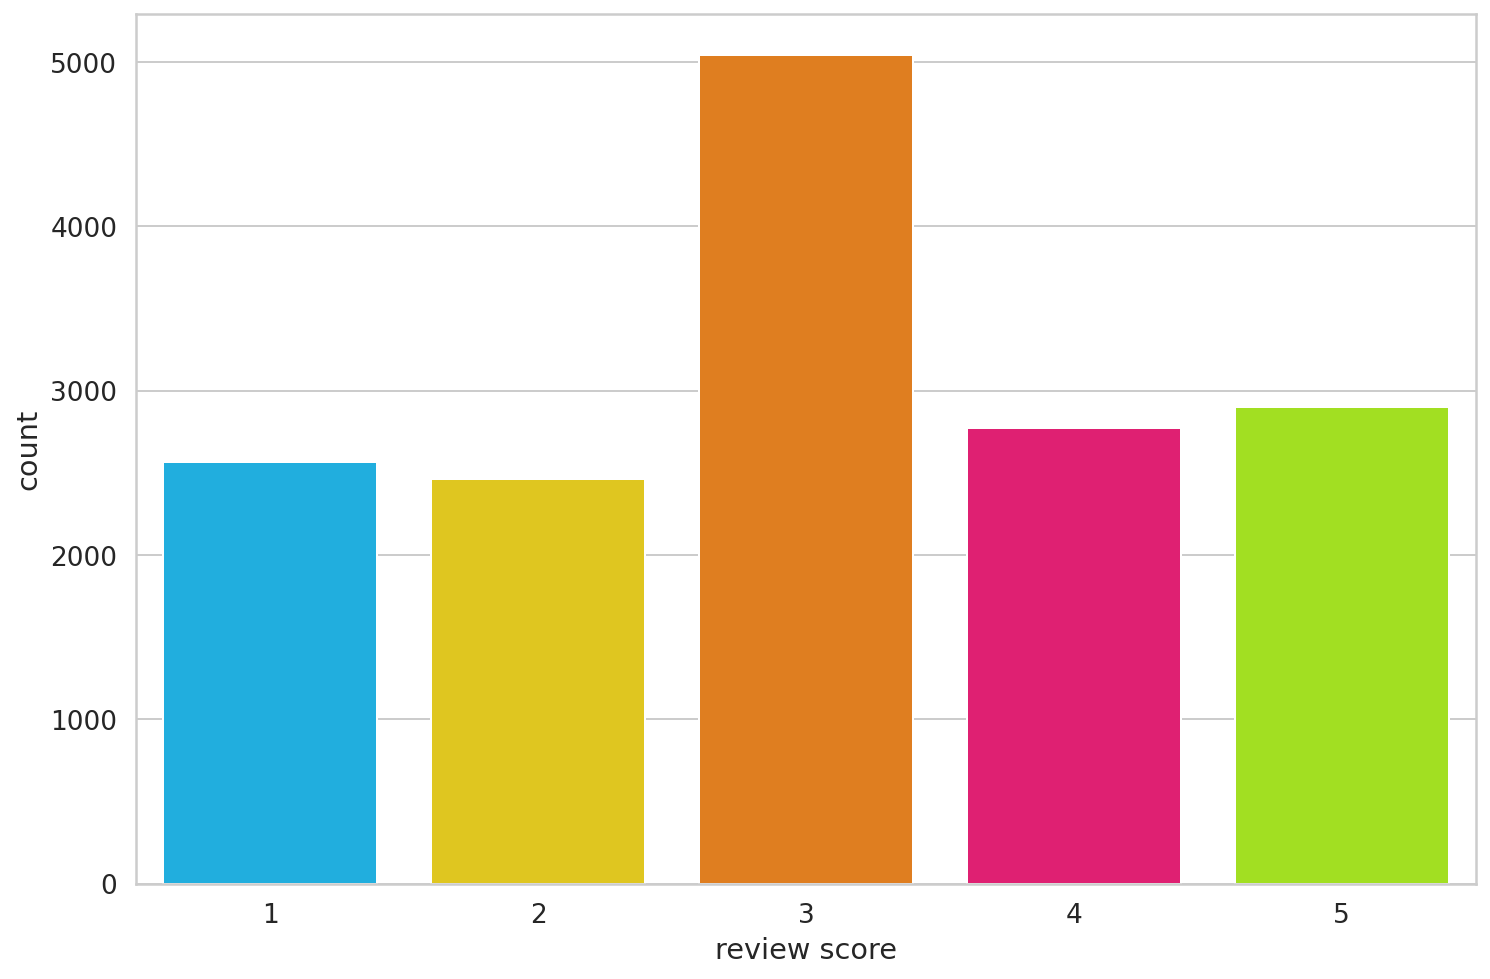

In [77]:
sns.countplot(data.score)
plt.xlabel('review score');
plt.show()

that is hugely imbalance , but it's okay  , we are going to cenvert the dataset into Negative , Positive and Neutral

In [78]:
data.score.value_counts()

3    5042
5    2900
4    2776
1    2566
2    2462
Name: score, dtype: int64

In [79]:
def intSentiment(sentiment):
  sentiment = int(sentiment)
  if sentiment < 3 :
    return 0
  if sentiment == 3:
    return 1
  if sentiment > 3:
    return 2

In [80]:
# transform setiment form 1 to 5 into 3 class positive "2" , neutral "1"  , negtive " 0"
data['sentiment'] = data['score'].apply(intSentiment)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Negative'), Text(0, 0, 'Neutral'), Text(0, 0, 'Positive')]

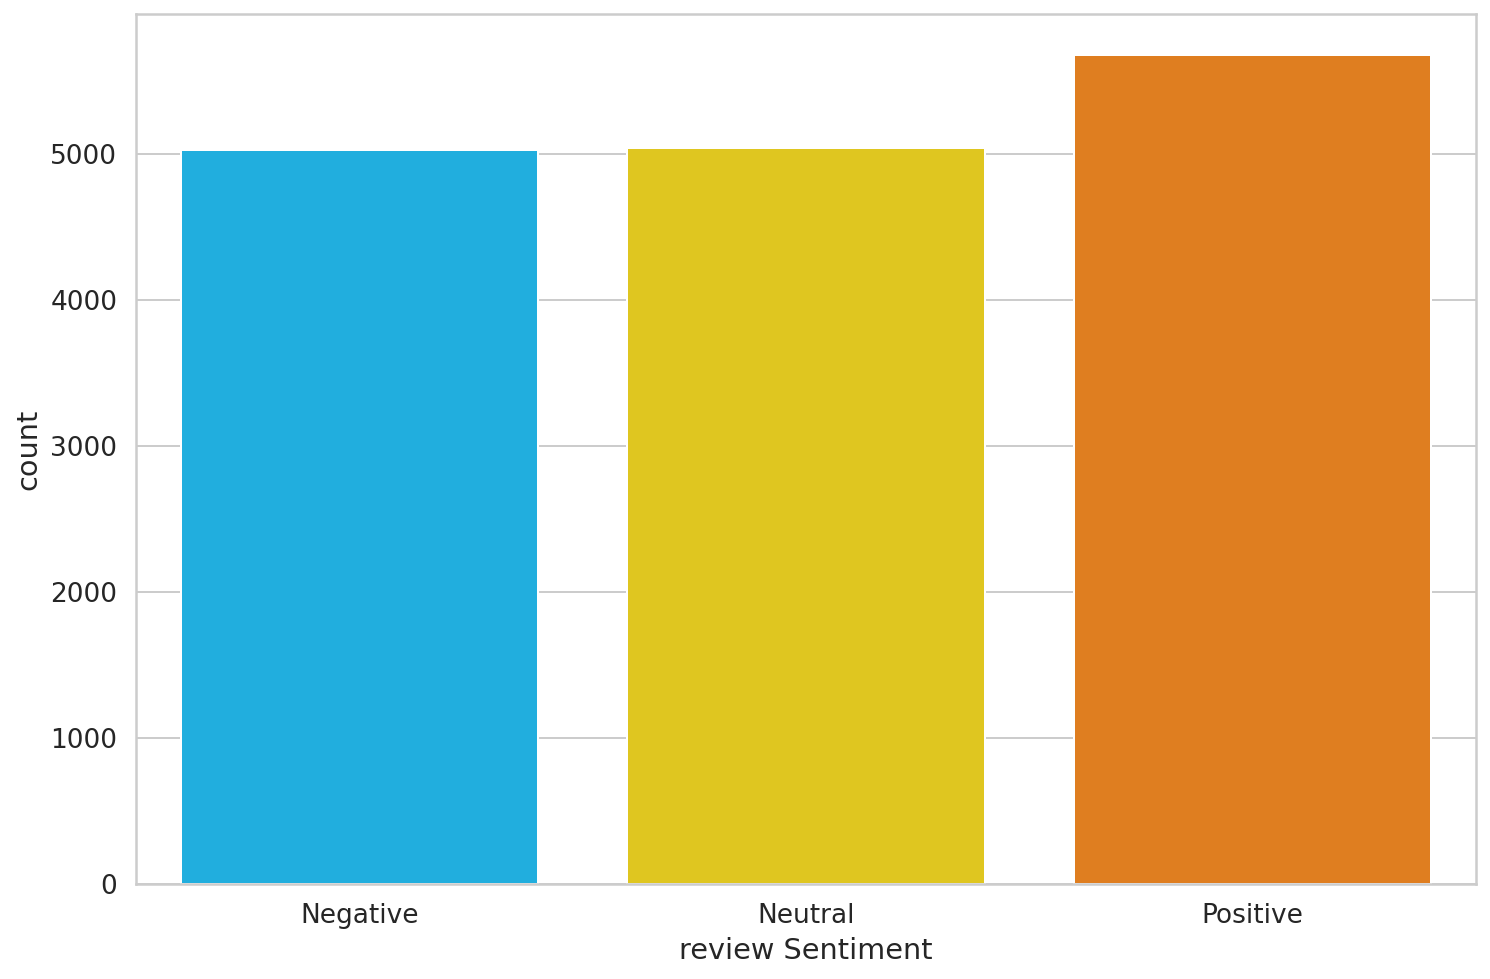

In [81]:
classNames = ['Negative','Neutral','Positive']

ax = sns.countplot(data['sentiment'])
plt.xlabel('review Sentiment')
ax.set_xticklabels(classNames)

The balance was  restored "Mostly"

## Data Preprocessing


you might already know that machine learning models don't work with raw text, You need to convert text to numbers

In [82]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

The Transformers library provides a wide variety of Transformer models (including BERT)

In [83]:
# Let’s load a pre-trained BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


we will use this text to understand the tokenization process

In [84]:
sampleText = 'When was I last outside? I am stuck at home for 2 weeks.'

some basic operations can convert text to tokens and tokens to unique integers

In [85]:
tokens = tokenizer.tokenize(sampleText)
tokensIds = tokenizer.convert_tokens_to_ids(tokens)

print(f"the Text is {sampleText} \n")
print(f"Tokens are {tokens} \n")
print(f"ids are {tokensIds}")

the Text is When was I last outside? I am stuck at home for 2 weeks. 

Tokens are ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.'] 

ids are [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Special Tokens

In [86]:
# [SEP] - marker for ending of a sentence
tokenizer.sep_token , tokenizer.sep_token_id

('[SEP]', 102)

In [87]:
# [CLS] - we must add this token to the start of each sentence, so BERT knows we’re doing classification
tokenizer.cls_token , tokenizer.cls_token_id

('[CLS]', 101)

In [88]:
# There is also a special token for padding:
tokenizer.pad_token , tokenizer.pad_token_id

('[PAD]', 0)

In [89]:
# BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token:
tokenizer.unk_token , tokenizer.unk_token_id

('[UNK]', 100)

all of that work can vo done unsing  **encoder_plus()** 

In [90]:
# `encode_plus` will:
#   (1) Tokenize the sentence.
#   (2) Prepend the `[CLS]` token to the start.
#   (3) Append the `[SEP]` token to the end.
#   (4) Map tokens to their IDs.
#   (5) Pad or truncate the sentence to `max_length`
#   (6) Create attention masks for [PAD] tokens.

encoding = tokenizer.encode_plus(
    sampleText,
    max_length=32,
    # add speical tokens [SEP] and [CLS]
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [91]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [92]:
encoding['input_ids']

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [93]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [94]:
print(len(encoding['input_ids'][0]))

32


In [95]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review:


In [96]:
tokensLen = []
for txt in data.content:
  tokens = tokenizer.encode(txt,max_length=512)
  tokensLen.append(len(tokens))

Text(0.5, 11.552000000000007, 'Token count')

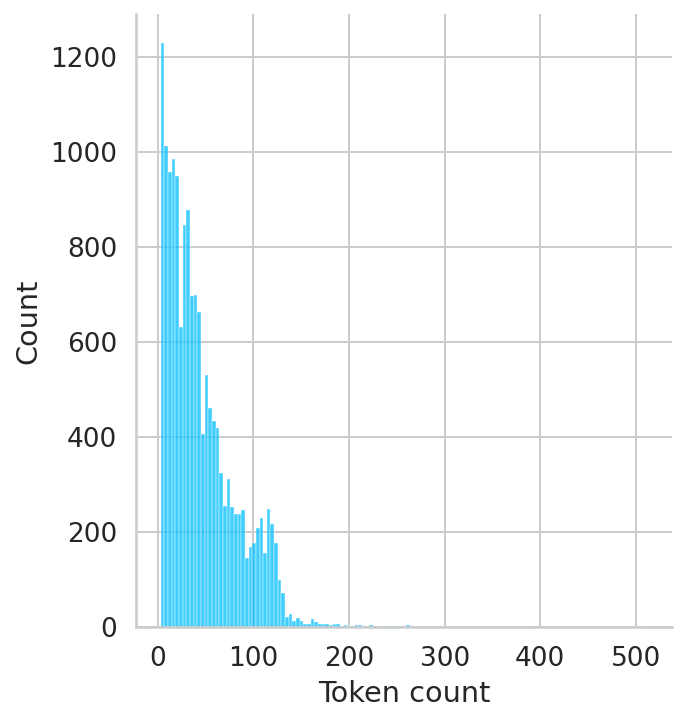

In [97]:
sns.displot(tokensLen)
plt.xlabel('Token count')

Most of the reviews seem to contain less than 128 tokens, but we’ll be on the safe side and choose a maximum length of 160.


In [98]:
maxLen = 160

In [99]:
class ReviewDataSet(Dataset):

  def __init__(self,reviews,targets , maxLen , tokenizer):

    self.reviews = reviews
    self.targets = targets
    self.maxLen = maxLen
    self.tokenizer = tokenizer
  
  def __len__(self):
    return len(self.reviews)

  def __getitem__(self,item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens = True,
        max_length=self.maxLen,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',    
    )

    return {
        "review" : review,
        "input_ids" : encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
    }

Split our data into train , test , validation

In [100]:
dfTrain , dfTest = train_test_split(data , test_size=0.1 ,
                                    random_state=42 )

dfVal , dfTest = train_test_split(dfTest , test_size=0.5 ,
                                    random_state=42)

In [182]:
print(f'Training Set shape is {dfTrain.shape}')
print(f'validation Set shape is {dfVal.shape}')
print(f'testing Set shape is {dfTest.shape}')

Training Set shape is (14171, 12)
validation Set shape is (787, 12)
testing Set shape is (788, 12)


build a function to create a Dataloader for each dataset

In [101]:
def CreateDataLoader( data , maxLen , tokenizer,batchSize):

  df = ReviewDataSet(
      reviews = data['content'].to_numpy(),
      targets = data['sentiment'].to_numpy(),
      maxLen = maxLen,
      tokenizer = tokenizer
  )

  return DataLoader(
      df , 
      batchSize,
      num_workers=2
  )

We also need to create a couple of data loaders. Here’s a helper function to do it:



In [102]:
batchSize = 16
trainLoader = CreateDataLoader(dfTrain,maxLen,tokenizer,batchSize)
testLoader = CreateDataLoader(dfTest,maxLen,tokenizer,batchSize)
valLoader = CreateDataLoader(dfVal,maxLen,tokenizer,batchSize)

let's look at an batch from our training set

In [103]:
data = next(iter(trainLoader))
print(data.keys())

dict_keys(['review', 'input_ids', 'attention_mask', 'targets'])


In [104]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)


torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model:

In [105]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 `last_hidden_state` is a sequence of hidden state of last layer of the model


In [106]:
out = bert_model(
    encoding['input_ids'],
    encoding['attention_mask']
)

In [107]:
out[0].shape

torch.Size([1, 32, 768])

`last hidden state` shape is 1 > batch size , 32 sequence length , 768 number of hidden units

In [108]:
out['last_hidden_state'].shape

torch.Size([1, 32, 768])

`pooler_output` , this layer transform the output from [batch size , sequence length , hidden size ] to [batch size , hidden size ] 

In [109]:
out['pooler_output'].shape

torch.Size([1, 768])

In [110]:
bert_model.config.hidden_size

768

Create a Classifier that uses bert model

In [111]:
class BertClassifier(nn.Module):

  def __init__(self,num_classer):
    super(BertClassifier,self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    self.dropout = nn.Dropout(p=0.3)

    self.linear = nn.Linear(self.bert.config.hidden_size,num_classer)

  def forward(self,input_ids, attention_mask):

    output = self.bert(input_ids,
                                  attention_mask)
    out = self.dropout(output['pooler_output'])
    out = self.linear(out)

    return out

This should work like any other PyTorch model. Let’s create an instance and move it to the GPU


In [112]:
model = BertClassifier(len(classNames))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [113]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


### to get predicted probalilties from our trained model , we will apply softmax function to the outputs 

In [114]:
F.softmax(model(input_ids, attention_mask),
              dim = 1)

tensor([[0.2332, 0.4717, 0.2951],
        [0.2219, 0.3612, 0.4168],
        [0.3589, 0.2427, 0.3984],
        [0.2221, 0.3218, 0.4561],
        [0.5762, 0.2056, 0.2181],
        [0.2249, 0.4422, 0.3329],
        [0.2750, 0.3181, 0.4069],
        [0.3732, 0.2454, 0.3813],
        [0.3927, 0.1892, 0.4181],
        [0.3349, 0.1948, 0.4703],
        [0.3043, 0.2263, 0.4695],
        [0.3710, 0.1894, 0.4396],
        [0.2090, 0.4449, 0.3462],
        [0.3396, 0.2594, 0.4010],
        [0.3456, 0.2260, 0.4284],
        [0.1500, 0.3302, 0.5198]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Training 

we’ll use the `AdamW` optimizer provided by Hugging Face. It corrects weight decay, so it’s similar to the original paper. We’ll also use a `linear scheduler with no warmup steps` :


In [116]:
num_epochs = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
lossFn = nn.CrossEntropyLoss().to(device)

total_steps = len(trainLoader) * num_epochs
print(f"total steps is {total_steps}")


# Create a schedule with a learning rate that decreases following the values of the cosine function between the initial lr set in the optimizer to 0,
# after a warmup period during which it increases linearly between 0 and the initial lr set in the optimizer.

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
      num_training_steps=total_steps
)

total steps is 8860


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4

In [154]:
def train_epoch(
    model ,
    data_loader,
    lossFn,
    optimizer,
    device,
    scheduler,
    num_examples):
  
  # out the model into training mode
  model = model.train()

  losses = []
  train_accuracy = []

  # for each batch of training data
  for d in data_loader:

      # Zero out any previously calculated gradients
    #model.zero_grad()


    # forward 
    #print(d)
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    target = d['targets'].to(device)

    # preform a forward pass
    model_out = model(
        input_ids,
        attention_mask
    )

    _,y_pred = torch.max(model_out, dim=1)

    
    # compute the loos
    loss = lossFn(model_out,target)

    #compute the accuracy
    accuracy = (y_pred == target).cpu().numpy().mean() * 100

    # compute accumulate accuracy
    train_accuracy.append(accuracy)
    # compute accumulate loss
    losses.append(loss.item())



    # perform a backward pass to compute the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # Update parameters and the learning rate
    optimizer.step()
    scheduler.step()

    # Zero out any previously calculated gradients
    optimizer.zero_grad()

  # Compute the average accuracy and loss over the training set.
  return np.mean(train_accuracy), np.mean(losses)

In [156]:
l1 = torch.tensor([1,2,3])
l2 = torch.tensor([1,3,3])
torch.sum(l1==l2)

tensor(2)

In [157]:
def eval_model(
    model,
    data_loader,
    loss_fn,
    device,
    num_examples
          ):
  
  # put the model into evaluation mode
  #The dropout layers are disabled during the test time.
  model = model.eval()

  # tracking variables
  losses = []
  val_accuracy = []

  with torch.no_grad():
    # For each batch in our validation set...
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      target = d['targets'].to(device)

      # preform forward pass
      model_output = model(input_ids=input_ids,
        attention_mask=attention_mask )
      # Get the predictions
      _ , predction = torch.max(model_output,dim=1)

       # Compute loss
      loss = loss_fn(model_output,target)

      accuracy = (predction == target).cpu().numpy().mean() * 100

      val_accuracy.append(accuracy)

      losses.append(loss.item())
    # Compute the average accuracy and loss over the validation set.
    return np.mean(val_accuracy), np.mean(losses)


In [158]:
%%time

history = defaultdict(list)
best_accuracy = 0

# start training loop
for epoch in range(num_epochs):

  print(f'Epoch {epoch + 1}/{num_epochs}')
  print('-' * 10)


  train_accuracy , train_loss = train_epoch(model=model , data_loader =trainLoader , 
                                            lossFn=lossFn,optimizer=optimizer,
                                            device =device, scheduler=scheduler,
                                            num_examples=len(dfTrain))
  
  print(f'Train loss {train_loss} accuracy {train_accuracy}')

  val_accuracy  , val_loss = eval_model(model = model, data_loader = valLoader,
                                        loss_fn = lossFn,device = device,num_examples = len(dfVal))
  
  print(f'Val   loss {val_loss} accuracy {val_accuracy}')

  history['train_accuracy'].append(train_accuracy)
  history['train_loss'].append(train_loss)
  history['val_accuracy'].append(val_accuracy)
  history['val_loss'].append(val_loss)

  if val_accuracy > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_accuracy

Epoch 1/10
----------
Train loss 0.7363976171202369 accuracy 66.82485122101374
Val   loss 0.5958692875504493 accuracy 75.29166666666667
Epoch 2/10
----------
Train loss 0.46876072741489916 accuracy 82.49217627744716
Val   loss 0.5582373827695847 accuracy 80.79166666666667
Epoch 3/10
----------
Train loss 0.2823740720778334 accuracy 90.93602503591217
Val   loss 0.5566778092458844 accuracy 84.29166666666666
Epoch 4/10
----------
Train loss 0.19169866845918856 accuracy 94.73053047404063
Val   loss 0.6051110040582717 accuracy 86.41666666666666
Epoch 5/10
----------
Train loss 0.14566811644217276 accuracy 96.1804843012518
Val   loss 0.7657489902968518 accuracy 85.29166666666666
Epoch 6/10
----------
Train loss 0.10708268697732407 accuracy 97.18217730350914
Val   loss 0.693839955998119 accuracy 86.79166666666666
Epoch 7/10
----------
Train loss 0.08316548488338181 accuracy 97.8273137697517
Val   loss 0.7644381563807837 accuracy 87.66666666666666
Epoch 8/10
----------
Train loss 0.06443531696

Note that we’re storing the state of the best model, indicated by the highest validation accuracy.

look at the training vs validation accuracy:


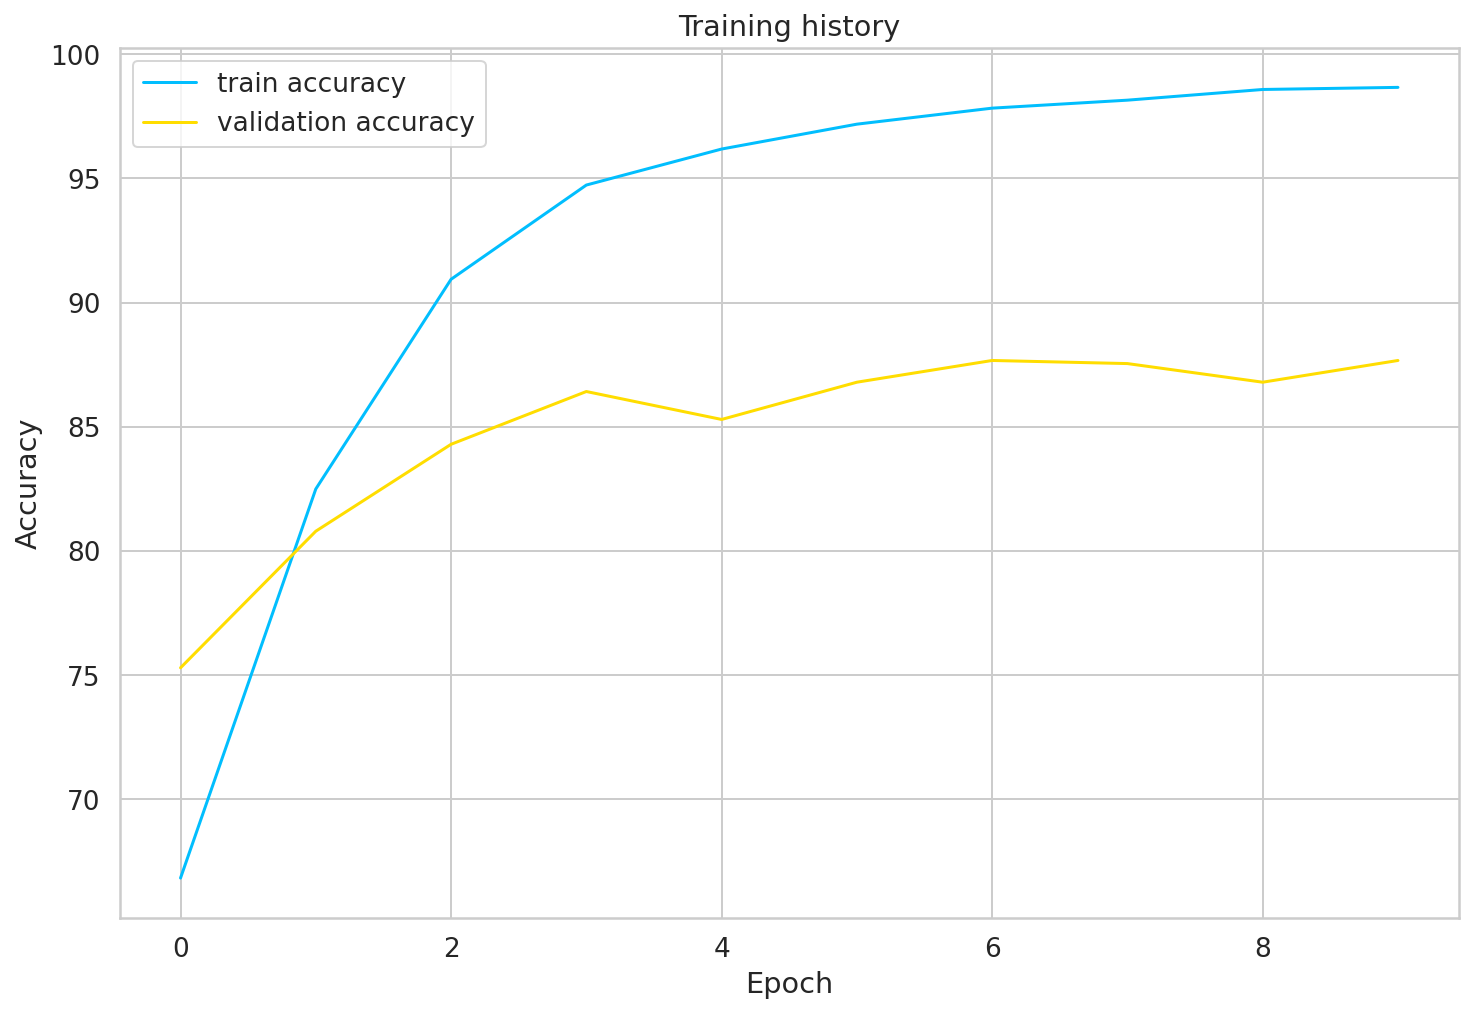

In [165]:
plt.plot(history['train_accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

So how good is our model on predicting sentiment? Let’s start by calculating the accuracy on the test data:


In [160]:
test_acc, _ = eval_model(
  model,
  testLoader,
  lossFn,
  device,
  len(dfTest)
)

89.125

In [172]:
print(f'Model Accuracy on the test set is {test_acc.item()}')

Model Accuracy on the test set is 89.125


### We’ll define a helper function to get the predictions from our model:



In [184]:
def get_predictions(model,data_loader):

  # put model into evaluation mode
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []


  with torch.no_grad():

    for d in data_loader:

      texts = d['review']
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      # preform forward pass

      model_output = model(
          input_ids,attention_mask
      )


      # get predictions 
      _, preds = torch.max(model_output,dim=1)

      # 
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(model_output)
      real_values.extend(targets)

      # 'stack' Concatenates a sequence of tensors along a new dimension.

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return review_texts , predictions , prediction_probs , real_values

In [185]:
review_texts, pred, pred_probs, y_test = get_predictions(
  model,
  testLoader
)

let's have a look at the classification report

In [186]:
print(classification_report(y_test, pred, target_names=classNames))

              precision    recall  f1-score   support

    Negative       0.90      0.87      0.88       245
     Neutral       0.84      0.87      0.85       254
    Positive       0.92      0.93      0.93       289

    accuracy                           0.89       788
   macro avg       0.89      0.89      0.89       788
weighted avg       0.89      0.89      0.89       788



looks like it is realy hard to classify neutral reviews 

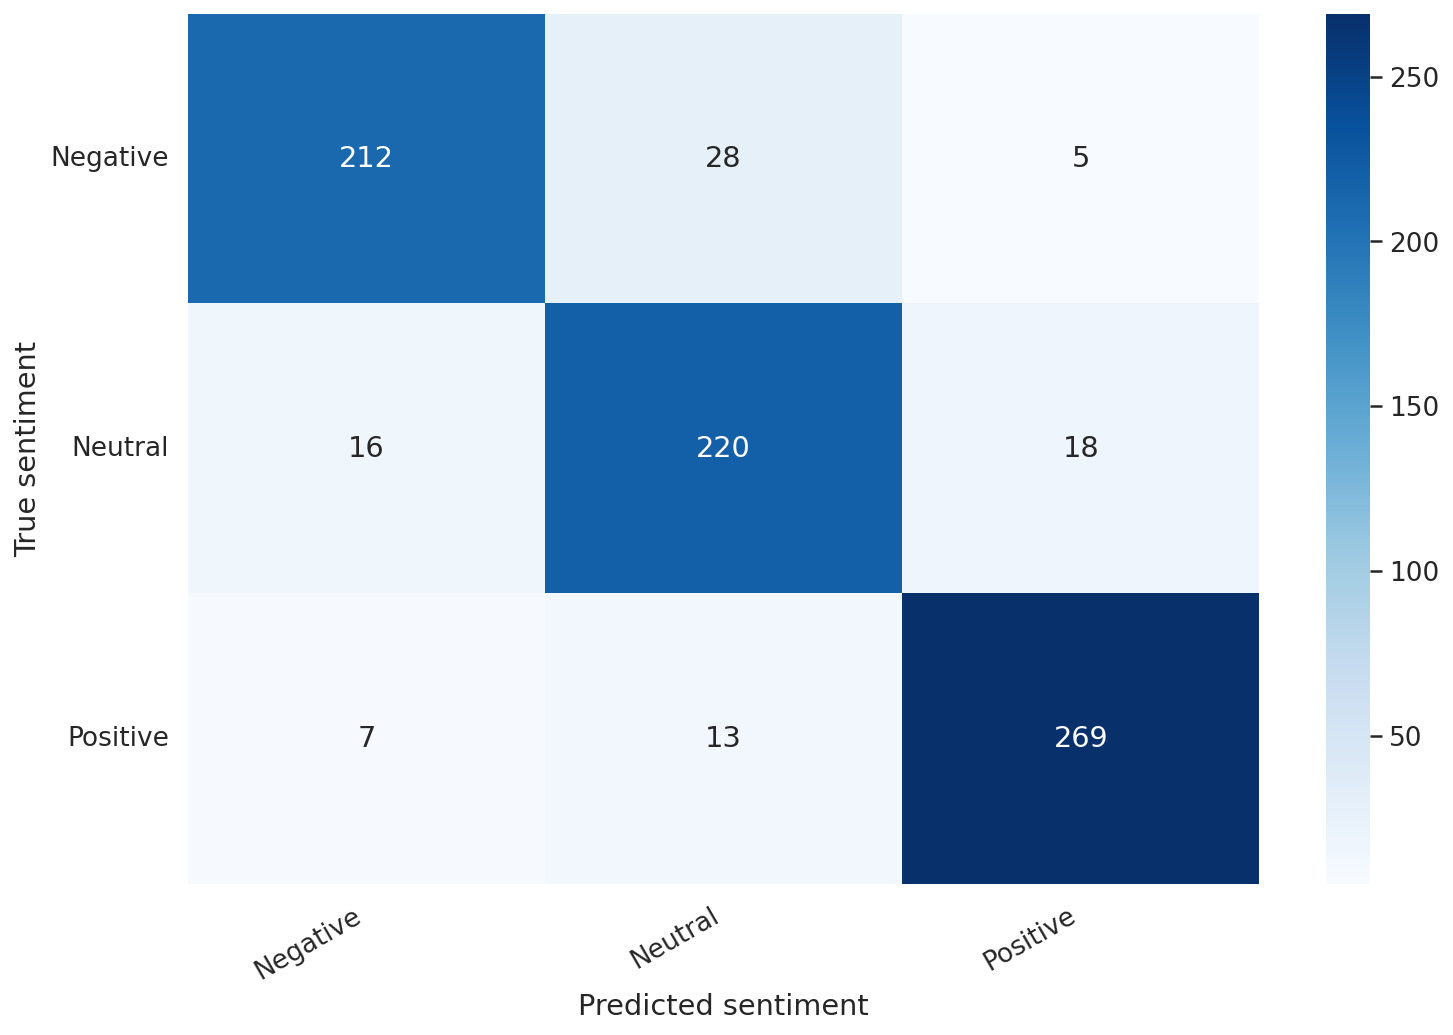

In [187]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=classNames, columns=classNames)
show_confusion_matrix(df_cm)

**Predicting on Raw Text**    
Let’s use our model to predict the sentiment of some raw text:


In [188]:
review_text = "I love completing my todos! Best app ever!!!"

In [190]:
review_encoding = tokenizer.encode_plus(
    review_text,
    max_length=32,
    # add speical tokens [SEP] and [CLS]
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [192]:
input_ids = review_encoding['input_ids'].to(device)
attention_mask = review_encoding['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {classNames[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : Positive
